In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
from ltsfit.lts_linefit import lts_linefit

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
Dist_i = pd.read_csv("MLratio_i_distances_noCorrection.csv", sep=',')

for col in Dist_i.columns:
    newcol = col.strip()
    Dist_i.rename(columns={col:newcol}, inplace=True)
Dist_i = Dist_i.set_index("PGC")

Dist_i = Dist_i[["DM_75","DMi_fid"]]

Dist_i.head()

,DM_75,DMi_fid
PGC,,
4,34.011709,33.411845
16,34.491034,34.646527
55,34.167913,33.811232
68,35.108989,34.868603
70,34.900087,35.358661


In [4]:
Dist_z = pd.read_csv("MLratio_z_distances_noCorrection.csv", sep=',')

for col in Dist_z.columns:
    newcol = col.strip()
    Dist_z.rename(columns={col:newcol}, inplace=True)
Dist_z = Dist_z.set_index("PGC")

Dist_z = Dist_z[["DMz_fid"]]

Dist_z.head()

,DMz_fid
PGC,
4,33.433917
16,34.589261
55,33.820304
68,34.778487
70,35.264078


In [5]:
Dist_riz = pd.read_csv("MLratio_riz_distances_noCorrection.csv", sep=',')

for col in Dist_riz.columns:
    newcol = col.strip()
    Dist_riz.rename(columns={col:newcol}, inplace=True)
Dist_riz = Dist_riz.set_index("PGC")

Dist_riz = Dist_riz[["DMriz_fid"]]

Dist_riz.head()

,DMriz_fid
PGC,
4,33.426808
16,34.623880
55,33.812618
68,34.817386
70,35.321309


In [6]:
df = pd.read_csv("btfr_brent_updated.csv", sep='|')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
    
df = df.set_index("PGC")   

df = df[["Vls"]]

df.head()

,Vls
PGC,
2,5296
4,4706
12,6685
16,5809
55,5052


In [7]:
df = Dist_i.join(Dist_riz).join(Dist_z).join(df)

df.head()

,DM_75,DMi_fid,DMriz_fid,DMz_fid,Vls
PGC,,,,,
4,34.011709,33.411845,33.426808,33.433917,4706
16,34.491034,34.646527,34.623880,34.589261,5809
55,34.167913,33.811232,33.812618,33.820304,5052
68,35.108989,34.868603,34.817386,34.778487,7740
70,34.900087,35.358661,35.321309,35.264078,7040


In [8]:
df = df[df.Vls>4000]

In [9]:
DM_i = df["DMi_fid"].values
DM_z = df["DMz_fid"].values
DM_riz = df["DMriz_fid"].values
DM_75 = df["DM_75"].values

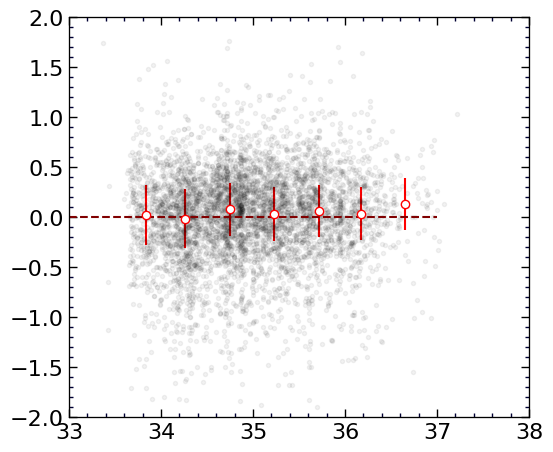

In [10]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(DM_75, DM_riz-DM_75, 'k.', alpha=0.05)

X = DM_75
Y = DM_riz-DM_75

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

for i in np.arange(27,37,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(yp, 0.1)
        Q3 = np.quantile(yp, 0.9)
        
        xp = xp[((yp>Q1)&(yp<Q3))]
        yp = yp[((yp>Q1)&(yp<Q3))]
              
        if len(xp)>5:
            
            x  = np.median(xp)
            y  = np.median(yp)
            yerr = np.std(yp)
            
            ax.errorbar(x, y, yerr=yerr, fmt='o', 
                    color='red', ms=6, mfc='white') 
            
set_axes(ax, (33,38), (-2,2))
ax.plot([33,37],[0,0], '--', color='maroon')


In [11]:
np.mean(Y)

-0.001960229600852844